# Anomaly detection: non-privileged ports

This notebook describes a method to detect anomalies in the TCP and UDP ports used by processes for outgoing communication. In particular, it considers the number of different non-privileged ports used by certain images.
<div class="alert alert-info">
    Note: an image can roughly be considered equal to the executable file for a program.
</div>

First, we import some libraries and set configuration parameters.

In [1]:
import datetime
import pandas as pd
import os
import json

import elasticsearch
import elasticsearch.helpers
import urllib3

import concurrent

import sys
sys.path.append('/opt/2IMS40')

# Import files from current directory
from search_index import search_index
from es_client import es_client

## The next part is copied from (template) code for the course 2IAB0 - Data Analytics for Engineers
# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn
## End copied part

es_client = es_client(local=True)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/usr/local/lib/python3.8/dist-packages/elasticsearch/_sync/client/__init__.py:394: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


First, we retrieve all events from the Sysmon logs which have a destination port set. All of these events should be network traffic events.

In [2]:
# Find process creations
df = search_index(es_client, "_exists_:Event.EventData.DestinationPort AND source: sysmon.json").dropna(how='all', axis=1)

df

_index      _id             sort  \
0    host_events    30807  [1670579502712]   
1    host_events    30808  [1670579502713]   
2    host_events    30809  [1670579502713]   
3    host_events    30810  [1670579502713]   
4    host_events    31146  [1670579502992]   
..           ...      ...              ...   
462  host_events  4521131  [1671820553547]   
463  host_events  4521994  [1671820578574]   
464  host_events  4521995  [1671820578574]   
465  host_events  4524067  [1671820634409]   
466  host_events  4525142  [1671820774582]   

                                 Event.EventData.Image  \
0                                               System   
1                                               System   
2                      C:\Windows\System32\svchost.exe   
3                      C:\Windows\System32\svchost.exe   
4                      C:\Windows\System32\svchost.exe   
..                                                 ...   
462  C:\Program Files (x86)\Microsoft\Edge\Applicat...   
463                                             System   
464                                             System   
465  C:\Program Files (x86)\Microsoft\Edge\Applicat...   
466  C:\Program Files (x86)\Microsoft\Edge\Applicat...   

              Event.EventData.ProcessGuid  Event.EventData.ProcessId  \
0    EDA6DF62-051C-6393-EB03-000000000000                        4.0   
1    EDA6DF62-051C-6393-EB03-000000000000                        4.0   
2    EDA6DF62-0529-6393-2700-000000002100                     1892.0   
3    EDA6DF62-0529-6393-2700-000000002100                     1892.0   
4    EDA6DF62-052B-6393-5A00-000000002100                     4236.0   
..                                    ...                        ...   
462  EDA6DF62-C90A-63A5-A400-000000002900                     6868.0   
463  EDA6DF62-C8DE-63A5-EB03-000000000000                        4.0   
464  EDA6DF62-C8DE-63A5-EB03-000000000000                        4.0   
465  EDA6DF62-C90A-63A5-A400-000000002900                     6868.0   
466  EDA6DF62-C90A-63A5-A400-000000002900                     6868.0   

    Event.EventData.RuleName          Event.EventData.User  \
0                          -           NT AUTHORITY\SYSTEM   
1                          -           NT AUTHORITY\SYSTEM   
2                          -  NT AUTHORITY\NETWORK SERVICE   
3                          -  NT AUTHORITY\NETWORK SERVICE   
4                          -           NT AUTHORITY\SYSTEM   
..                       ...                           ...   
462                        -           WINDEV2211EVAL\User   
463                        -           NT AUTHORITY\SYSTEM   
464                        -           NT AUTHORITY\SYSTEM   
465                        -           WINDEV2211EVAL\User   
466                        -           WINDEV2211EVAL\User   

     Event.EventData.UtcTime                  Event.System.Channel  ...  \
0    2022-12-09 09:51:39.374  Microsoft-Windows-Sysmon/Operational  ...   
1    2022-12-09 09:51:39.375  Microsoft-Windows-Sysmon/Operational  ...   
2    2022-12-09 09:51:40.060  Microsoft-Windows-Sysmon/Operational  ...   
3    2022-12-09 09:51:40.071  Microsoft-Windows-Sysmon/Operational  ...   
4    2022-12-09 09:51:40.106  Microsoft-Windows-Sysmon/Operational  ...   
..                       ...                                   ...  ...   
462  2022-12-23 18:36:14.322  Microsoft-Windows-Sysmon/Operational  ...   
463  2022-12-23 18:36:41.552  Microsoft-Windows-Sysmon/Operational  ...   
464  2022-12-23 18:36:41.553  Microsoft-Windows-Sysmon/Operational  ...   
465  2022-12-23 18:38:14.320  Microsoft-Windows-Sysmon/Operational  ...   
466  2022-12-23 18:40:14.339  Microsoft-Windows-Sysmon/Operational  ...   

    Event.EventData.DestinationPort  Event.EventData.DestinationPortName  \
0                             137.0                           netbios-ns   
1                             137.0                           netbios-ns   
2                    

Before we continue, we slightly clean the data by changing the image names to lower-case. This is appropriate, because Windows uses case-insensitive paths, and, seemingly, the image names in Sysmon-reported events use varying casing.

In [3]:
# Clean file names to lower case
df['Event.EventData.Image'] = df['Event.EventData.Image'].apply(str.lower)

Next, we take a look at the unique destination port numbers occurring in this data.

In [4]:
ports = df['Event.EventData.DestinationPort'].unique().astype(int)
ports.sort()
ports

array([   53,    67,    80,   123,   137,   389,   443,   547,  1900,
        5353,  5355,  6606, 27017, 27018, 27019, 27021, 27022, 27023,
       27024, 27025, 27028, 27029, 27030, 27031, 27032, 27033, 27034,
       27035, 27036, 27037, 27038, 49317, 49318, 49730, 49732, 49743,
       49745, 49858, 49860, 49985, 49989, 50066, 50068, 50184, 50186,
       50398, 50399, 50907, 50908, 51408, 51410, 51534, 51809, 51811,
       52074, 52075, 52513, 52515, 53017, 53019, 53361, 53362, 54090,
       54092, 54564, 54567, 54609, 54612, 54652, 54657, 54660, 54721,
       54728, 54731, 55185, 55187, 55658, 55660, 55914, 55915, 56031,
       56032, 56124, 56242, 56521, 56756, 56757, 56994, 56996, 57225,
       57343, 57345, 57465, 57781, 57782, 57891, 57893, 57917, 57918,
       58079, 58080, 58497, 58784, 58785, 58786, 58787, 58794, 58796,
       59113, 59115, 59673, 59674, 59810, 60628, 60629, 61497, 61498,
       61649, 61651, 61896, 61898, 62813, 62815, 62843, 62845, 63000,
       63002, 64305,

It can be seen that there is quite a variety of port numbers. Most of them are high, seemingly random port numbers. However, a few ports are well-known ports, i.e. those below 1024, which require (admin) privileges to open. Since these are more often than not _(but not always)_ used for benign purposes, an initial idea is to remove these from consideration. We do this in the cells below. First, we look at how many events use a privileged port.

In [5]:
df['PrivilegedPort'] = df['Event.EventData.DestinationPort'] < 1024
df['PrivilegedPort'].value_counts()

True     8614
False    1853
Name: PrivilegedPort, dtype: int64

It seems that the vast majority of events indeed use a privileged port. Next, we see what images use non-privileged ports.

In [6]:
df[df['PrivilegedPort'] == False]['Event.EventData.Image'].unique()

array(['c:\\windows\\system32\\svchost.exe',
       'c:\\program files (x86)\\microsoft\\edge\\application\\msedge.exe',
       '<unknown process>', 'c:\\program files (x86)\\steam\\steam.exe',
       'c:\\users\\user\\appdata\\local\\mozilla firefox\\firefox.exe',
       'c:\\program files\\mozilla firefox\\firefox.exe',
       'c:\\windows\\microsoft.net\\framework\\v4.0.30319\\regsvcs.exe'],
      dtype=object)

This is a surprisingly low number of images, which, importantly, still contains the image `C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe`, which is known to have been used by the malware.

Next, we consider the transport layer protocol used in the communication. More specifically, we consider whether the traffic uses UDP or TCP.

In [7]:
df[df['PrivilegedPort'] == False]['Event.EventData.Protocol'].value_counts()

udp    1746
tcp     107
Name: Event.EventData.Protocol, dtype: int64

Now, the vast majority of the traffic uses UDP, whereas the malware is known to use TCP. Hence, it makes sense to further reduce the size of our dataset by eliminating all events related to UDP traffic from further consideration.

In [8]:
df[(df['PrivilegedPort'] == False) & (df['Event.EventData.Protocol'] == 'tcp')]['Event.EventData.Image'].unique()

array(['<unknown process>', 'c:\\program files (x86)\\steam\\steam.exe',
       'c:\\users\\user\\appdata\\local\\mozilla firefox\\firefox.exe',
       'c:\\program files\\mozilla firefox\\firefox.exe',
       'c:\\windows\\microsoft.net\\framework\\v4.0.30319\\regsvcs.exe'],
      dtype=object)

As seen in the cell above, this leaves us with only 5 images, one of which (still) is associated with the malware. Next, we will have a look at the ports used by these images.

In [9]:
ports = df[(df['PrivilegedPort'] == False) & (df['Event.EventData.Protocol'] == 'tcp')]['Event.EventData.DestinationPort'].unique().astype(int)
ports.sort()
ports

array([ 6606, 27019, 27021, 27022, 27023, 27024, 27025, 27028, 27029,
       27030, 27031, 27032, 27033, 27034, 27035, 27036, 27037, 27038,
       49730, 49732, 49743, 49745, 49858, 49860, 49985, 49989, 50066,
       50068, 51534, 54564, 54567, 54609, 54612, 54657, 54660, 54721,
       54728, 54731, 56242, 57225, 57465, 58497, 58784, 58786, 59113,
       59115, 59810, 62843, 62845])

The filtering conducted above has already reduced the number of ports quite significantly. Next, we will try to visualize the data we have so far. In particular, we will show the ports used by each image using a heatmap-style visualization.

/tmp/ipykernel_144773/4148716046.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pi_matrix = pi.pivot("DestinationPort", "Image", "count").fillna(0)


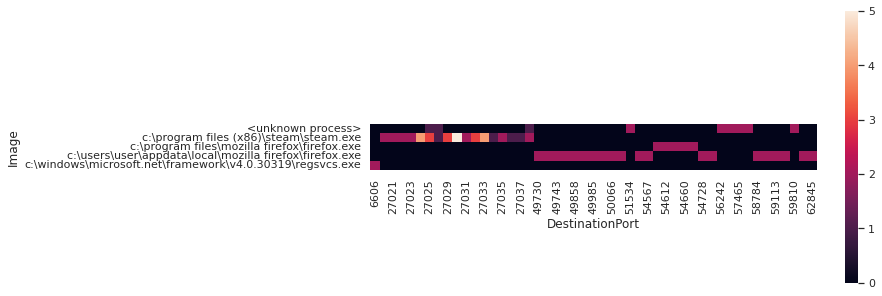

In [10]:
# This code is strongly based on code used in the course 2IAB0 (Data Analytics for Engineers).
ports_and_images = df[(df['PrivilegedPort'] == False) & (df['Event.EventData.Protocol'] == 'tcp')][['Event.EventData.DestinationPort', 'Event.EventData.Image']]
ports_and_images['Event.EventData.DestinationPort'] = ports_and_images['Event.EventData.DestinationPort'].astype(int)
ports_and_images.rename({'Event.EventData.DestinationPort': 'DestinationPort', 'Event.EventData.Image': 'Image'}, axis=1, inplace=True)

ports_and_images['count'] = 0
pi = ports_and_images.groupby(["DestinationPort", "Image"]).count().reset_index()

# fill the NaN values with 0's
pi["count"] = pi["count"].fillna(0)

# pivot the table
pi_matrix = pi.pivot("DestinationPort", "Image", "count").fillna(0)

sns.heatmap(pi_matrix.transpose(), square=True);

In this figure, it is quickly seen that all images use multiple non-privileged TCP ports, except for the image `regsvcs.exe`, which is associated with the malware. This seems like an interesting anomaly to further investigate. To summarize this finding, we generate a bar chart which shows the number of non-privileged TCP ports opened per image.

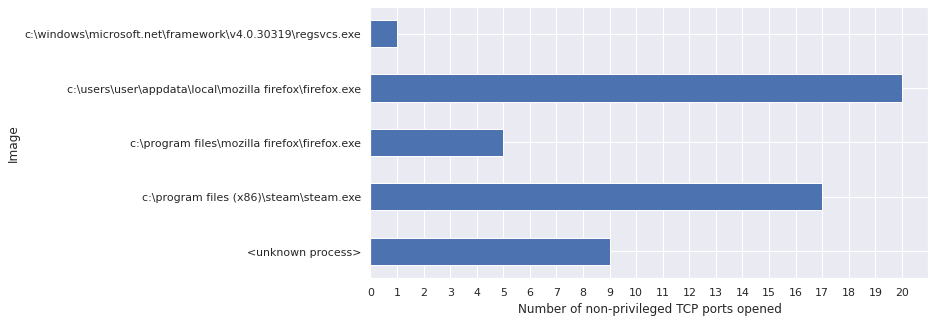

In [11]:
# Based on https://stackoverflow.com/a/34156147/2378368
pi_matrix.astype(bool).sum().plot.barh(
    # kind='bar',
    xticks=[i for i in range(0,21)],
    xlabel='Number of non-privileged TCP ports opened'
);

Once again, this confirms our idea that only the malware-associated image opens a single non-privileged TCP port. This can be considered anomalous behaviour, which (for our limited dataset) does not lead to any false positives.

## Computing true/false postives/negatives

In this section, we compute the number of true positives, true negatives, false positives and false negatives, as well as some metrics related to these quantities. Before we continue, it is useful to define all of these quantities:
- The number of true positives is the number of images (which are run as a process) which use exactly one port, and which are in the process tree of a known malware process;
- The number of true negatives is the number of images (which are run as a process) which use more than one port, and which are not in the process tree of a known malware process;
- The number of false positives is the number of images (which are run as a process) which use exactly one port, and which are not in the process tree of a known malware process;
- The number of false negatives is the number of images (which are run as a process) which use more than one port, and which are in the process tree of a known malware process.

For the purposes of the above definition, the known malware processes are those associated with one of the following images:
- `C:\Users\User\Downloads\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe`
- `C:\Users\User\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Startup\Systdeeem.exe`

<div class="alert alert-info">
    Note: the following 5 images are in the process trees of any of the known malware processes:
    <ul>
        <li><code>C:\Users\User\Downloads\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe</code> (known malware process)</li>
        <li><code>C:\Users\User\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Startup\Systdeeem.exe</code> (known malware process)</li>
        <li><code>C:\Windows\SysWOW64\WindowsPowerShell\v1.0\powershell.exe</code></li>
        <li><code>C:\Windows\System32\conhost.exe</code></li>
        <li><code>C:\Windows\Microsoft.NET\Framework\v4.0.30319\RegSvcs.exe</code></li>
    </ul>
</div>

In [12]:
# These are the malware images, as given above, but encoded into properly 'formatted' strings for use in Python:
malware_images = set([
    'C:\\Users\\User\\Downloads\\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe'.lower(),
    'C:\\Users\\User\\AppData\\Roaming\\Microsoft\\Windows\\Start Menu\\Programs\\Startup\\Systdeeem.exe'.lower(),
    'C:\\Windows\\SysWOW64\\WindowsPowerShell\\v1.0\\powershell.exe'.lower(),
    'C:\\Windows\\System32\\conhost.exe'.lower(),
    'C:\\Windows\\Microsoft.NET\\Framework\\v4.0.30319\\RegSvcs.exe'.lower()
])
malware_images

{'c:\\users\\user\\appdata\\roaming\\microsoft\\windows\\start menu\\programs\\startup\\systdeeem.exe',
 'c:\\users\\user\\downloads\\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe',
 'c:\\windows\\microsoft.net\\framework\\v4.0.30319\\regsvcs.exe',
 'c:\\windows\\system32\\conhost.exe',
 'c:\\windows\\syswow64\\windowspowershell\\v1.0\\powershell.exe'}

<div class="alert alert-warning">
    Note: we only count images which are run as a process; that is, images which are associated with an event with ID 1 (process created). This is mostly done for simplicity, since all network connection events in the logs are associated with a process, and we can only associate an image with such an event through a process.
</div>

Using the set of malware images given above, the number of true positives is the number of images which occur in this set and also use one port, which is computed below:

In [13]:
true_positives = len(malware_images.intersection(set(pi_matrix.columns[pi_matrix.astype(bool).sum() == 1])))
true_positives

1

To compute the number of false negatives, we simply take the set difference instead:

In [14]:
false_negatives = len(malware_images.difference(set(pi_matrix.columns[pi_matrix.astype(bool).sum() == 1])))
false_negatives

4

Next, the number of false positives is the number of elements which are not in the set of malware images, but which do occur in the set of images which use one port:

In [15]:
false_positives = len(set(pi_matrix.columns[pi_matrix.astype(bool).sum() == 1]).difference(malware_images))
false_positives

0

Finally, the number of true negatives is the number of images which are involved in network connections, but which have not been detected as a true positive, false negative or false positive. This gives:

In [16]:
true_negatives = len(df['Event.EventData.Image'].unique()) - true_positives - false_negatives - false_positives
true_negatives

46

Finally, we compute some metrics using these quantities:

In [17]:
accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
FPR = false_positives / (false_positives + true_negatives) # false positive rate
TNR = true_negatives / (false_positives + true_negatives)
F1_score = 2 * precision * recall / (precision + recall)

print("Accuracy            = " + "{0:.3f}".format(accuracy))
print("Precision           = " + "{0:.3f}".format(precision))
print("Recall              = " + "{0:.3f}".format(recall))
print("False Positive Rate = " + "{0:.3f}".format(FPR))
print("True  Negative Rate = " + "{0:.3f}".format(TNR))
print("F1-score            = " + "{0:.3f}".format(F1_score))

Accuracy            = 0.922
Precision           = 1.000
Recall              = 0.200
False Positive Rate = 0.000
True  Negative Rate = 1.000
F1-score            = 0.333


# Considering both TCP and UDP ports

Some time later, we discussed our earlier assumption to restrict ourselves to TCP ports only. Since this restriction is somewhat arbitrary, it might be interesting to see whether considering UDP ports as well introduces false positives; if not, we can generalize the anomaly without sacrificing performance.

To this end, we use code which is almost exactly the same as before, but with some variable names changed and the restriction to TCP ports removed. This results in the following:

/tmp/ipykernel_144773/3676470168.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pi_matrix_udp = pi.pivot("DestinationPort", "Image", "count").fillna(0)


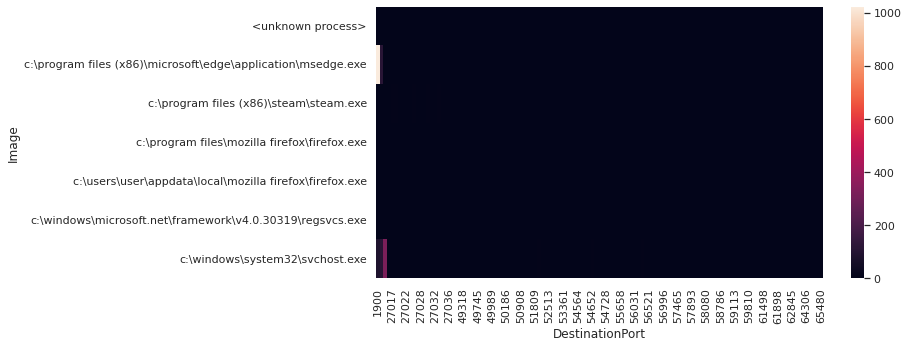

In [18]:
# This code is strongly based on code used in the course 2IAB0 (Data Analytics for Engineers).
ports_and_images = df[(df['PrivilegedPort'] == False)][['Event.EventData.DestinationPort', 'Event.EventData.Image']]
ports_and_images['Event.EventData.DestinationPort'] = ports_and_images['Event.EventData.DestinationPort'].astype(int)
ports_and_images.rename({'Event.EventData.DestinationPort': 'DestinationPort', 'Event.EventData.Image': 'Image'}, axis=1, inplace=True)

ports_and_images['count'] = 0
pi = ports_and_images.groupby(["DestinationPort", "Image"]).count().reset_index()

# fill the NaN values with 0's
pi["count"] = pi["count"].fillna(0)

# pivot the table
pi_matrix_udp = pi.pivot("DestinationPort", "Image", "count").fillna(0)

sns.heatmap(pi_matrix_udp.transpose(), square=False);

Due to scaling, the heatmap is insufficiently informative. However, the bar chart, which is shown below, gives more satisfactory results:

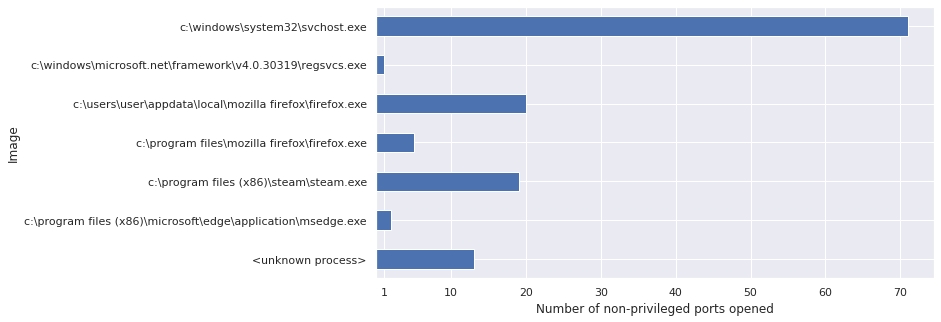

In [19]:
# Based on https://stackoverflow.com/a/34156147/2378368
pi_matrix_udp.astype(bool).sum().plot.barh(
    # kind='bar',
    # xticks=iris_matrix.astype(bool).sum().unique(),
    xticks=list(set([1]).union([i for i in range(10, 71, 10)])),
    xlabel='Number of non-privileged ports opened'
);

<div class="alert alert-success">
    Once again, only the malware-associated image opens communications with exactly one non-privileged port. This can still be considered an anomaly-based detection strategy which does not incur false positives.
</div>

One downside of including UDP ports in addition to TCP ports is that this reduces the adjustability of the method; since we now have to consider a benign image (Microsoft Edge) which uses 2 ports, we cannot increase the number of non-privileged ports to account for an attacker who uses a small number of ports in a trivial manner.

## Computing true/false postives/negatives

In this section, we compute the number of true positives, true negatives, false positives and false negatives, as well as some metrics related to these quantities. Before we continue, it is useful to define all of these quantities:
- The number of true positives is the number of images (which are run as a process) which use exactly one port, and which are in the process tree of a known malware process;
- The number of true negatives is the number of images (which are run as a process) which use more than one port, and which are not in the process tree of a known malware process;
- The number of false positives is the number of images (which are run as a process) which use exactly one port, and which are not in the process tree of a known malware process;
- The number of false negatives is the number of images (which are run as a process) which use more than one port, and which are in the process tree of a known malware process.

For the purposes of the above definition, the known malware processes are those associated with one of the following images:
- `C:\Users\User\Downloads\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe`
- `C:\Users\User\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Startup\Systdeeem.exe`

<div class="alert alert-info">
    Note: the following 5 images are in the process trees of any of the known malware processes:
    <ul>
        <li><code>C:\Users\User\Downloads\2ecbf5a27adc238af0b125b985ae2a8b1bc14526faea3c9e40e6c3437245d830.exe</code> (known malware process)</li>
        <li><code>C:\Users\User\AppData\Roaming\Microsoft\Windows\Start Menu\Programs\Startup\Systdeeem.exe</code> (known malware process)</li>
        <li><code>C:\Windows\SysWOW64\WindowsPowerShell\v1.0\powershell.exe</code></li>
        <li><code>C:\Windows\System32\conhost.exe</code></li>
        <li><code>C:\Windows\Microsoft.NET\Framework\v4.0.30319\RegSvcs.exe</code></li>
    </ul>
</div>

<div class="alert alert-warning">
    Note: we only count images which are run as a process; that is, images which are associated with an event with ID 1 (process created). This is mostly done for simplicity, since all network connection events in the logs are associated with a process, and we can only associate an image with such an event through a process.
</div>

Using the set of malware images given above, the number of true positives is the number of images which occur in this set and also use one port, which is computed below:

In [20]:
true_positives = len(malware_images.intersection(set(pi_matrix_udp.columns[pi_matrix_udp.astype(bool).sum() == 1])))
true_positives

1

To compute the number of false negatives, we simply take the set difference instead:

In [21]:
false_negatives = len(malware_images.difference(set(pi_matrix_udp.columns[pi_matrix_udp.astype(bool).sum() == 1])))
false_negatives

4

Next, the number of false positives is the number of elements which are not in the set of malware images, but which do occur in the set of images which use one port:

In [22]:
false_positives = len(set(pi_matrix_udp.columns[pi_matrix_udp.astype(bool).sum() == 1]).difference(malware_images))
false_positives

0

Finally, the number of true negatives is the number of images which are involved in network connections, but which have not been detected as a true positive, false negative or false positive. This gives:

In [23]:
true_negatives = len(df['Event.EventData.Image'].unique()) - true_positives - false_negatives - false_positives
true_negatives

46

Finally, we compute some metrics using these quantities:

In [24]:
accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
FPR = false_positives / (false_positives + true_negatives) # false positive rate
TNR = true_negatives / (false_positives + true_negatives)
F1_score = 2 * precision * recall / (precision + recall)

print("Accuracy            = " + "{0:.3f}".format(accuracy))
print("Precision           = " + "{0:.3f}".format(precision))
print("Recall              = " + "{0:.3f}".format(recall))
print("False Positive Rate = " + "{0:.3f}".format(FPR))
print("True  Negative Rate = " + "{0:.3f}".format(TNR))
print("F1-score            = " + "{0:.3f}".format(F1_score))

Accuracy            = 0.922
Precision           = 1.000
Recall              = 0.200
False Positive Rate = 0.000
True  Negative Rate = 1.000
F1-score            = 0.333
